## 1. Import Libraries

In [ ]:
# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)

# Cross-validation & tuning
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

# For timing
import time

print("Libraries loaded!")

✅ Libraries loaded!


## 2. Load Preprocessed Data

In [ ]:
# Load train/test splits from Notebook 01
X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').squeeze()
y_test = pd.read_csv('../data/processed/y_test.csv').squeeze()

# Load SMOTE-balanced training data
X_train_smote = pd.read_csv('../data/processed/X_train_smote.csv')
y_train_smote = pd.read_csv('../data/processed/y_train_smote.csv').squeeze()

# Load top features
top_features_df = pd.read_csv('../data/processed/top_features.csv')
top_features = top_features_df['feature'].tolist()

print("Data Loaded:")
print(f"   X_train: {X_train.shape} | y_train: {len(y_train)}")
print(f"   X_test: {X_test.shape} | y_test: {len(y_test)}")
print(f"   X_train_smote: {X_train_smote.shape} | y_train_smote: {len(y_train_smote)}")
print(f"\n   Top features loaded: {len(top_features)} features")

# Class distribution
print(f"\nClass Distribution:")
print(f"   Train (original): {dict(y_train.value_counts())}")
print(f"   Train (SMOTE): {dict(pd.Series(y_train_smote).value_counts())}")
print(f"   Test: {dict(y_test.value_counts())}")

📊 Data Loaded:
   X_train: (5455, 95) | y_train: 5455
   X_test: (1364, 95) | y_test: 1364
   X_train_smote: (10558, 95) | y_train_smote: 10558

   Top features loaded: 20 features

📈 Class Distribution:
   Train (original): {0: np.int64(5279), 1: np.int64(176)}
   Train (SMOTE): {0: np.int64(5279), 1: np.int64(5279)}
   Test: {0: np.int64(1320), 1: np.int64(44)}


## 3. Define Evaluation Functions

In [ ]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Comprehensive model evaluation for imbalanced classification.
    Returns dict of metrics.
    """
    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_prob) if y_prob is not None else None,
        'PR-AUC': average_precision_score(y_test, y_prob) if y_prob is not None else None
    }
    
    return metrics, y_pred, y_prob


def plot_confusion_matrix(y_test, y_pred, model_name, ax=None):
    """Plot confusion matrix."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Healthy', 'Bankrupt'],
                yticklabels=['Healthy', 'Bankrupt'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{model_name}\nConfusion Matrix')
    return ax


def plot_roc_curves(results_dict, y_test):
    """Plot ROC curves for all models."""
    plt.figure(figsize=(10, 8))
    
    for name, data in results_dict.items():
        if data['y_prob'] is not None:
            fpr, tpr, _ = roc_curve(y_test, data['y_prob'])
            auc = data['metrics']['ROC-AUC']
            plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})", linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)
    plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_precision_recall_curves(results_dict, y_test):
    """Plot Precision-Recall curves (important for imbalanced data)."""
    plt.figure(figsize=(10, 8))
    
    for name, data in results_dict.items():
        if data['y_prob'] is not None:
            precision, recall, _ = precision_recall_curve(y_test, data['y_prob'])
            ap = data['metrics']['PR-AUC']
            plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})", linewidth=2)
    
    # Baseline = proportion of positive class
    baseline = y_test.mean()
    plt.axhline(y=baseline, color='k', linestyle='--', label=f'Baseline ({baseline:.3f})')
    
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curves (Better for Imbalanced Data)', fontsize=14, fontweight='bold')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("Evaluation functions defined!")

✅ Evaluation functions defined!


---
## 4. Experiment 1: Baseline Models (No SMOTE, All Features)

In [ ]:
# Define models
models_baseline = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss', verbosity=0)
}

# Train and evaluate each model
results_baseline = {}
print("Training Baseline Models (No SMOTE, All Features)...\n")

for name, model in models_baseline.items():
    start = time.time()
    
    # Train
    model.fit(X_train, y_train)
    train_time = time.time() - start
    
    # Evaluate
    metrics, y_pred, y_prob = evaluate_model(model, X_test, y_test, name)
    metrics['Train Time (s)'] = round(train_time, 2)
    
    results_baseline[name] = {
        'model': model,
        'metrics': metrics,
        'y_pred': y_pred,
        'y_prob': y_prob
    }
    
    print(f"{name}:")
    print(f"   Accuracy: {metrics['Accuracy']:.3f} | F1: {metrics['F1']:.3f} | "
          f"Recall: {metrics['Recall']:.3f} | ROC-AUC: {metrics['ROC-AUC']:.3f}")
    print(f"   Training time: {train_time:.2f}s\n")

🚀 Training Baseline Models (No SMOTE, All Features)...

✅ Logistic Regression:
   Accuracy: 0.963 | F1: 0.219 | Recall: 0.159 | ROC-AUC: 0.873
   Training time: 0.18s

✅ Logistic Regression:
   Accuracy: 0.963 | F1: 0.219 | Recall: 0.159 | ROC-AUC: 0.873
   Training time: 0.18s

✅ Random Forest:
   Accuracy: 0.969 | F1: 0.250 | Recall: 0.159 | ROC-AUC: 0.932
   Training time: 1.92s

✅ Random Forest:
   Accuracy: 0.969 | F1: 0.250 | Recall: 0.159 | ROC-AUC: 0.932
   Training time: 1.92s

✅ XGBoost:
   Accuracy: 0.971 | F1: 0.451 | Recall: 0.364 | ROC-AUC: 0.941
   Training time: 1.73s

✅ XGBoost:
   Accuracy: 0.971 | F1: 0.451 | Recall: 0.364 | ROC-AUC: 0.941
   Training time: 1.73s



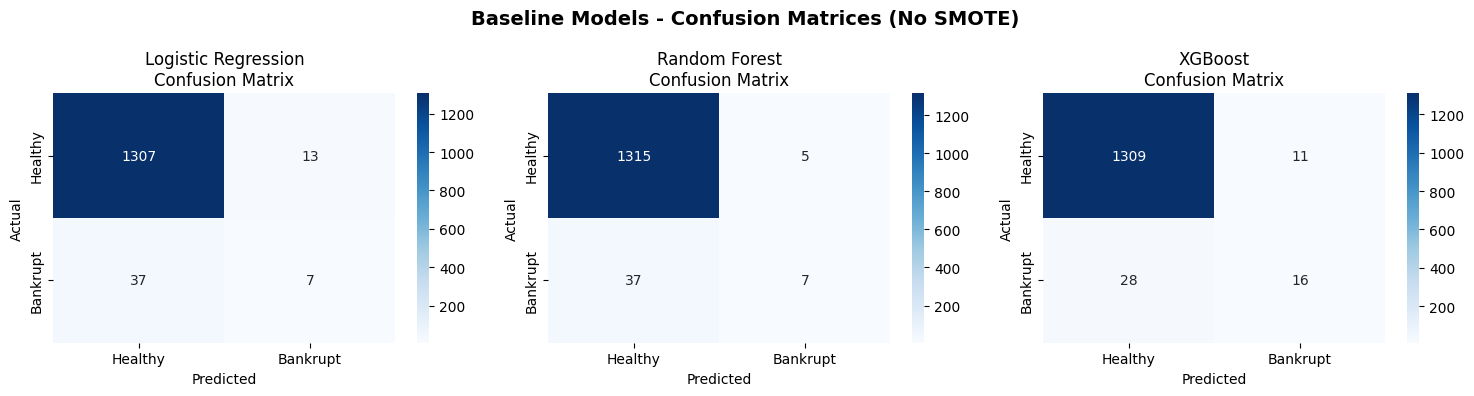


💡 Notice: Models may predict 'Healthy' for most samples (high accuracy but poor recall)
   This is the 'accuracy paradox' - we need to look at Recall and F1!


In [ ]:
# Confusion matrices for baseline models
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, data) in enumerate(results_baseline.items()):
    plot_confusion_matrix(y_test, data['y_pred'], name, axes[idx])

plt.suptitle('Baseline Models - Confusion Matrices (No SMOTE)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Key insight
print("\nNote: Models may predict 'Healthy' for most samples (high accuracy but poor recall)")
print("   This is the 'accuracy paradox' - we need to look at Recall and F1!")

---
## 5. Experiment 2: Models with SMOTE (Balanced Training)

In [ ]:
# Same models, trained on SMOTE-balanced data
models_smote = {
    'Logistic Regression (SMOTE)': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest (SMOTE)': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost (SMOTE)': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss', verbosity=0)
}

# Train and evaluate
results_smote = {}
print("Training Models with SMOTE-Balanced Data...\n")

for name, model in models_smote.items():
    start = time.time()
    
    # Train on SMOTE data
    model.fit(X_train_smote, y_train_smote)
    train_time = time.time() - start
    
    # Evaluate on ORIGINAL test set (never apply SMOTE to test!)
    metrics, y_pred, y_prob = evaluate_model(model, X_test, y_test, name)
    metrics['Train Time (s)'] = round(train_time, 2)
    
    results_smote[name] = {
        'model': model,
        'metrics': metrics,
        'y_pred': y_pred,
        'y_prob': y_prob
    }
    
    print(f"{name}:")
    print(f"   Accuracy: {metrics['Accuracy']:.3f} | F1: {metrics['F1']:.3f} | "
          f"Recall: {metrics['Recall']:.3f} | ROC-AUC: {metrics['ROC-AUC']:.3f}\n")

🚀 Training Models with SMOTE-Balanced Data...

✅ Logistic Regression (SMOTE):
   Accuracy: 0.893 | F1: 0.324 | Recall: 0.795 | ROC-AUC: 0.915

✅ Logistic Regression (SMOTE):
   Accuracy: 0.893 | F1: 0.324 | Recall: 0.795 | ROC-AUC: 0.915

✅ Random Forest (SMOTE):
   Accuracy: 0.962 | F1: 0.509 | Recall: 0.614 | ROC-AUC: 0.937

✅ Random Forest (SMOTE):
   Accuracy: 0.962 | F1: 0.509 | Recall: 0.614 | ROC-AUC: 0.937

✅ XGBoost (SMOTE):
   Accuracy: 0.966 | F1: 0.500 | Recall: 0.523 | ROC-AUC: 0.949

✅ XGBoost (SMOTE):
   Accuracy: 0.966 | F1: 0.500 | Recall: 0.523 | ROC-AUC: 0.949



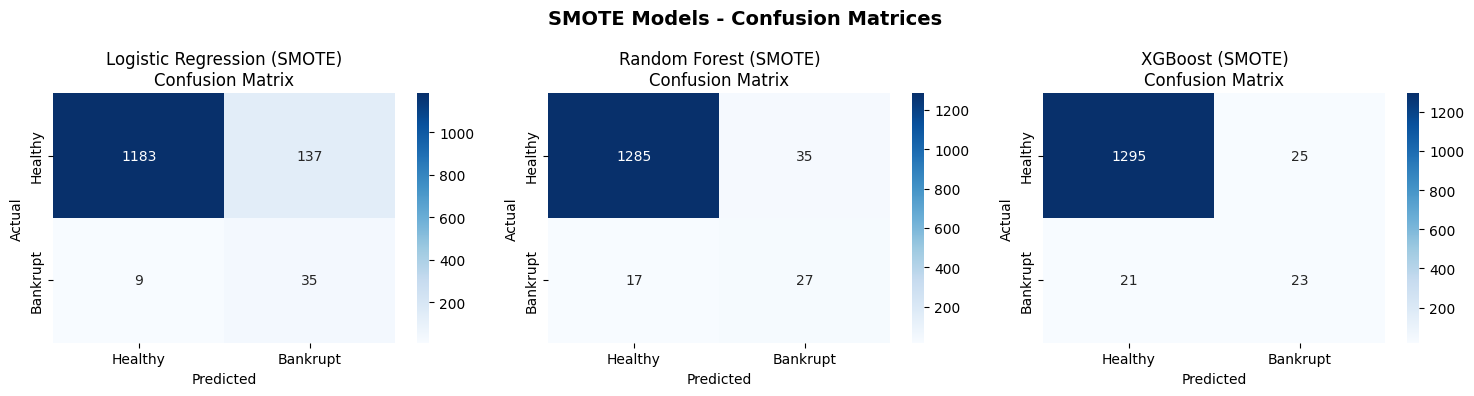

💡 SMOTE should improve Recall (detecting more bankruptcies) at cost of some Precision


In [ ]:
# Confusion matrices for SMOTE models
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, data) in enumerate(results_smote.items()):
    plot_confusion_matrix(y_test, data['y_pred'], name, axes[idx])

plt.suptitle('SMOTE Models - Confusion Matrices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Note: SMOTE should improve Recall (detecting more bankruptcies) at cost of some Precision")

---
## 6. Comparison: SMOTE vs No SMOTE

In [ ]:
# Create comparison DataFrame
all_results = []

for name, data in results_baseline.items():
    metrics = data['metrics'].copy()
    metrics['Experiment'] = 'No SMOTE'
    all_results.append(metrics)

for name, data in results_smote.items():
    metrics = data['metrics'].copy()
    metrics['Experiment'] = 'With SMOTE'
    all_results.append(metrics)

comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df[['Model', 'Experiment', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'PR-AUC']]

print("Full Comparison: SMOTE vs No SMOTE\n")
print(comparison_df.to_string(index=False))

📊 Full Comparison: SMOTE vs No SMOTE

                      Model Experiment  Accuracy  Precision   Recall       F1  ROC-AUC   PR-AUC
        Logistic Regression   No SMOTE  0.963343   0.350000 0.159091 0.218750 0.873037 0.263915
              Random Forest   No SMOTE  0.969208   0.583333 0.159091 0.250000 0.932292 0.462405
                    XGBoost   No SMOTE  0.971408   0.592593 0.363636 0.450704 0.940926 0.472927
Logistic Regression (SMOTE) With SMOTE  0.892962   0.203488 0.795455 0.324074 0.914618 0.336510
      Random Forest (SMOTE) With SMOTE  0.961877   0.435484 0.613636 0.509434 0.937388 0.450108
            XGBoost (SMOTE) With SMOTE  0.966276   0.479167 0.522727 0.500000 0.949122 0.514978


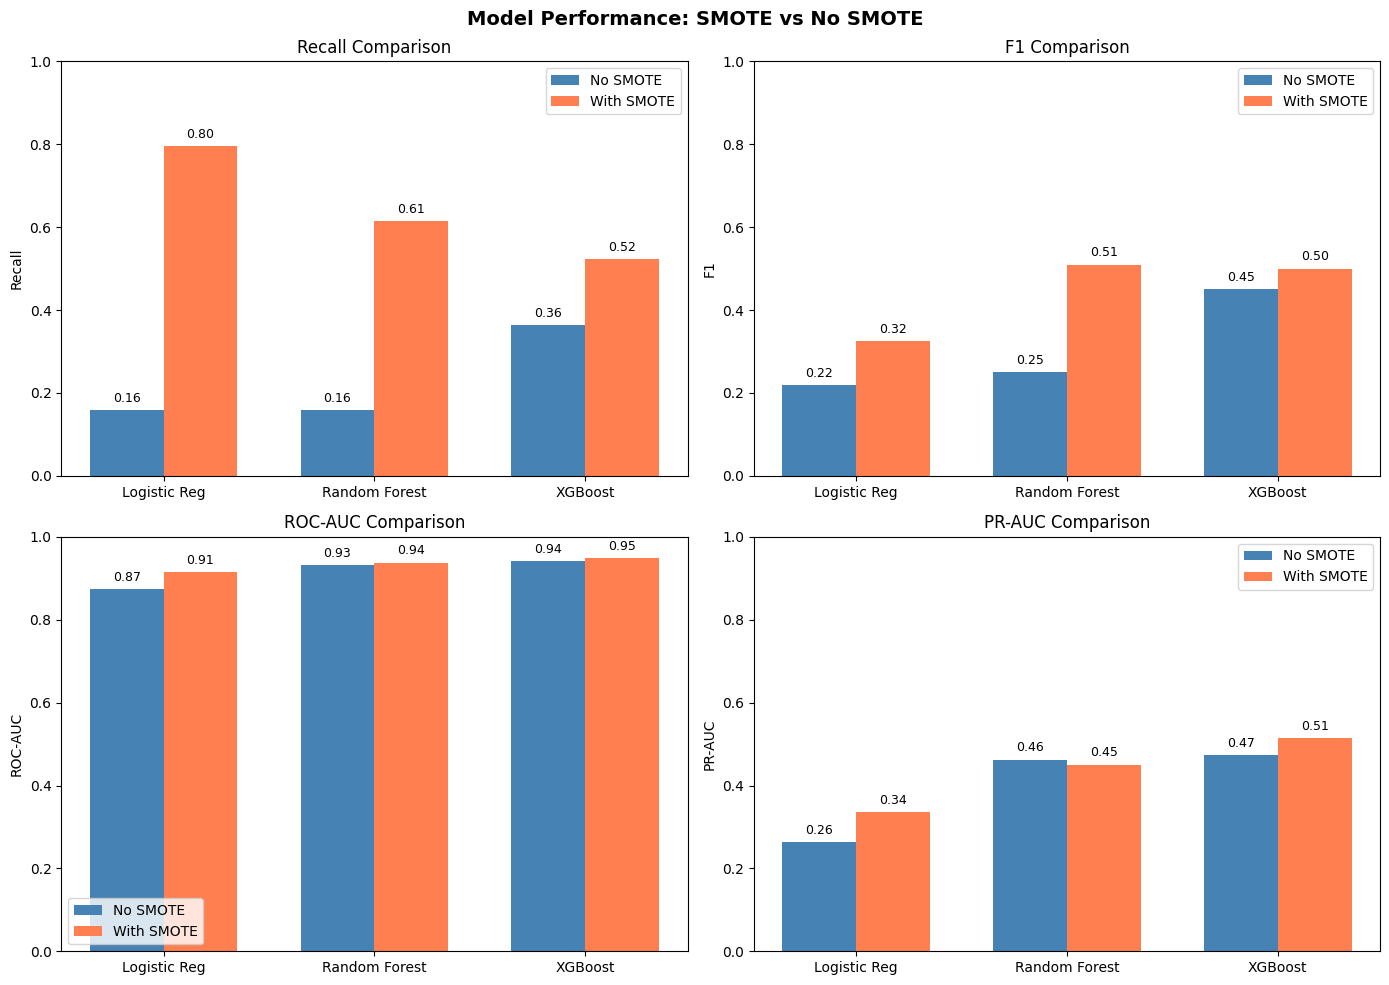

In [9]:
# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['Recall', 'F1', 'ROC-AUC', 'PR-AUC']
colors = {'No SMOTE': 'steelblue', 'With SMOTE': 'coral'}

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    # Group by model type (strip SMOTE suffix)
    baseline_vals = [results_baseline[m]['metrics'][metric] for m in ['Logistic Regression', 'Random Forest', 'XGBoost']]
    smote_vals = [results_smote[m]['metrics'][metric] for m in ['Logistic Regression (SMOTE)', 'Random Forest (SMOTE)', 'XGBoost (SMOTE)']]
    
    x = np.arange(3)
    width = 0.35
    
    ax.bar(x - width/2, baseline_vals, width, label='No SMOTE', color='steelblue')
    ax.bar(x + width/2, smote_vals, width, label='With SMOTE', color='coral')
    
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(['Logistic Reg', 'Random Forest', 'XGBoost'])
    ax.legend()
    ax.set_ylim(0, 1)
    
    # Add value labels
    for i, (b, s) in enumerate(zip(baseline_vals, smote_vals)):
        ax.text(i - width/2, b + 0.02, f'{b:.2f}', ha='center', fontsize=9)
        ax.text(i + width/2, s + 0.02, f'{s:.2f}', ha='center', fontsize=9)

plt.suptitle('Model Performance: SMOTE vs No SMOTE', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

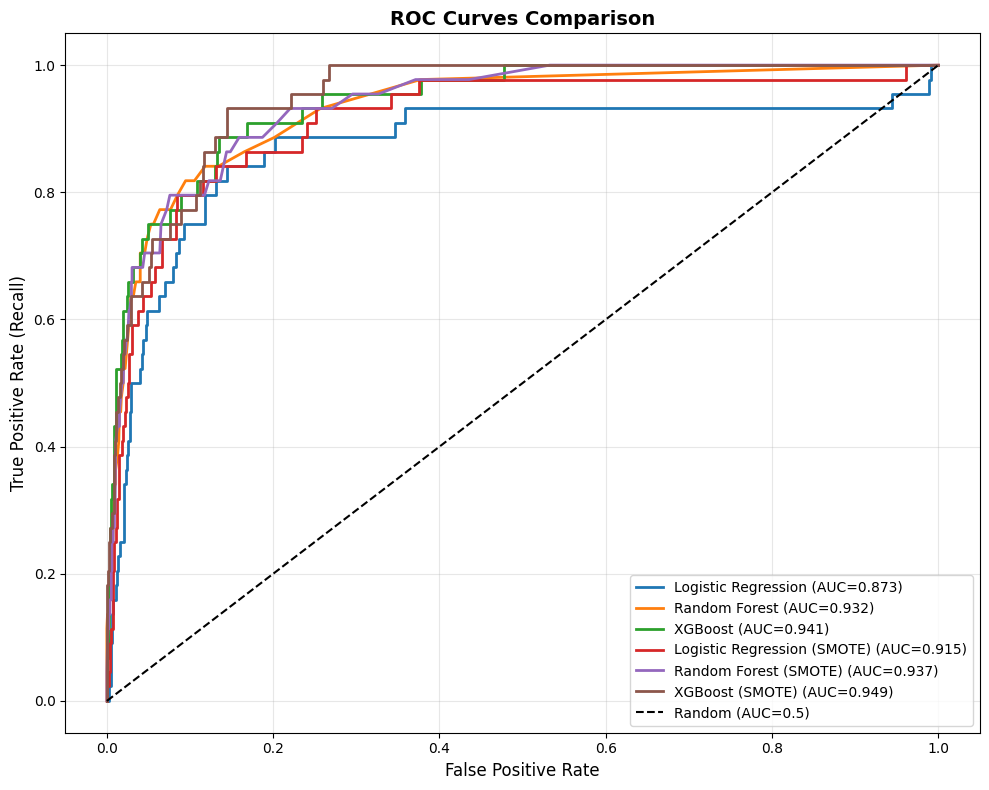

In [10]:
# ROC curves comparison
all_results_dict = {**results_baseline, **results_smote}
plot_roc_curves(all_results_dict, y_test)

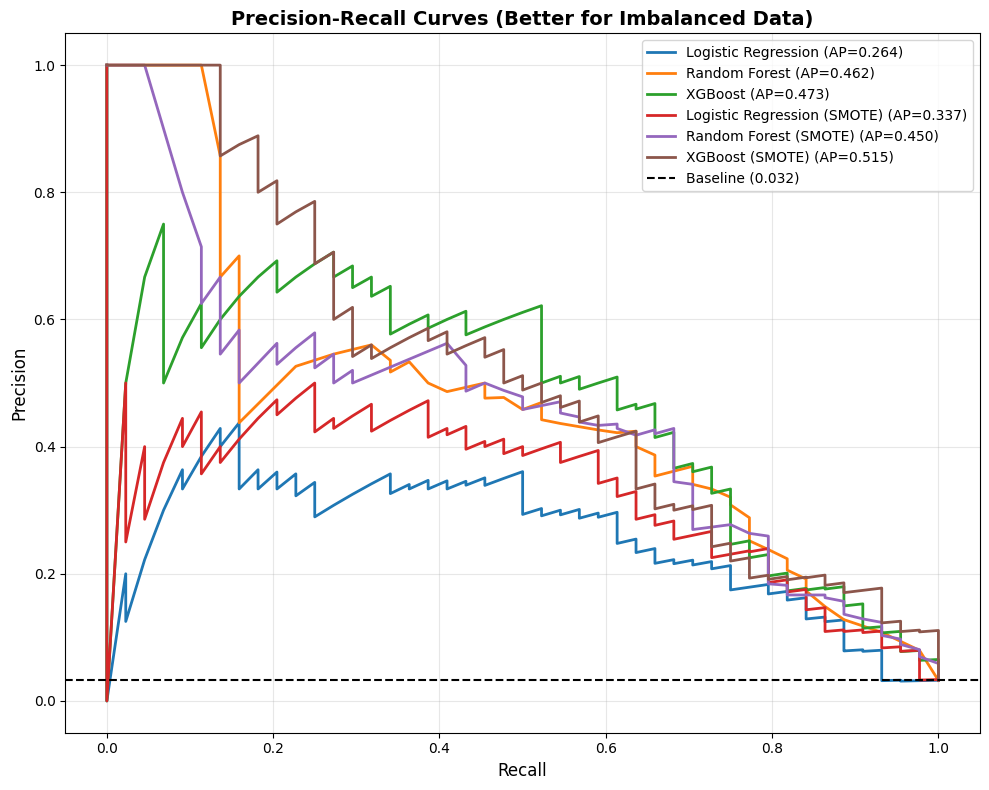

In [11]:
# Precision-Recall curves (more informative for imbalanced data)
plot_precision_recall_curves(all_results_dict, y_test)

---
## 7. Experiment 3: Top 20 Features Only

In [12]:
# Filter to top 20 features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]
X_train_smote_top = X_train_smote[top_features]

print(f"Using Top {len(top_features)} Features:")
for i, f in enumerate(top_features, 1):
    print(f"   {i:2}. {f}")

📊 Using Top 20 Features:
    1.  Net Income to Total Assets
    2.  ROA(A) before interest and % after tax
    3.  ROA(B) before interest and depreciation after tax
    4.  ROA(C) before interest and depreciation before interest
    5.  Net worth/Assets
    6.  Debt ratio %
    7.  Persistent EPS in the Last Four Seasons
    8.  Retained Earnings to Total Assets
    9.  Net profit before tax/Paid-in capital
   10.  Per Share Net profit before tax (Yuan ¥)
   11.  Current Liability to Assets
   12.  Working Capital to Total Assets
   13.  Net Income to Stockholder's Equity
   14.  Borrowing dependency
   15.  Current Liability to Current Assets
   16.  Liability to Equity
   17.  Net Value Per Share (A)
   18.  Net Value Per Share (B)
   19.  Net Value Per Share (C)
   20.  Current Liabilities/Equity


In [13]:
# Train XGBoost with SMOTE on top features (best combination expected)
models_top_features = {
    'XGBoost (SMOTE, Top 20)': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss', verbosity=0),
    'Random Forest (SMOTE, Top 20)': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

results_top = {}
print("Training on Top 20 Features with SMOTE...\n")

for name, model in models_top_features.items():
    start = time.time()
    model.fit(X_train_smote_top, y_train_smote)
    train_time = time.time() - start
    
    metrics, y_pred, y_prob = evaluate_model(model, X_test_top, y_test, name)
    metrics['Train Time (s)'] = round(train_time, 2)
    
    results_top[name] = {
        'model': model,
        'metrics': metrics,
        'y_pred': y_pred,
        'y_prob': y_prob
    }
    
    print(f"{name}:")
    print(f"   Accuracy: {metrics['Accuracy']:.3f} | F1: {metrics['F1']:.3f} | "
          f"Recall: {metrics['Recall']:.3f} | ROC-AUC: {metrics['ROC-AUC']:.3f}\n")

🚀 Training on Top 20 Features with SMOTE...

✅ XGBoost (SMOTE, Top 20):
   Accuracy: 0.935 | F1: 0.413 | Recall: 0.705 | ROC-AUC: 0.907

✅ XGBoost (SMOTE, Top 20):
   Accuracy: 0.935 | F1: 0.413 | Recall: 0.705 | ROC-AUC: 0.907

✅ Random Forest (SMOTE, Top 20):
   Accuracy: 0.935 | F1: 0.403 | Recall: 0.682 | ROC-AUC: 0.908

✅ Random Forest (SMOTE, Top 20):
   Accuracy: 0.935 | F1: 0.403 | Recall: 0.682 | ROC-AUC: 0.908



In [14]:
# Compare all features vs top 20
print("All Features (95) vs Top 20 Features:\n")

comparison_features = pd.DataFrame([
    {'Model': 'XGBoost (SMOTE)', 'Features': 'All 95', **{k: v for k, v in results_smote['XGBoost (SMOTE)']['metrics'].items() if k != 'Model'}},
    {'Model': 'XGBoost (SMOTE)', 'Features': 'Top 20', **{k: v for k, v in results_top['XGBoost (SMOTE, Top 20)']['metrics'].items() if k != 'Model'}},
    {'Model': 'Random Forest (SMOTE)', 'Features': 'All 95', **{k: v for k, v in results_smote['Random Forest (SMOTE)']['metrics'].items() if k != 'Model'}},
    {'Model': 'Random Forest (SMOTE)', 'Features': 'Top 20', **{k: v for k, v in results_top['Random Forest (SMOTE, Top 20)']['metrics'].items() if k != 'Model'}}
])

print(comparison_features[['Model', 'Features', 'Accuracy', 'Recall', 'F1', 'ROC-AUC']].to_string(index=False))

📊 All Features (95) vs Top 20 Features:

                Model Features  Accuracy   Recall       F1  ROC-AUC
      XGBoost (SMOTE)   All 95  0.966276 0.522727 0.500000 0.949122
      XGBoost (SMOTE)   Top 20  0.935484 0.704545 0.413333 0.906887
Random Forest (SMOTE)   All 95  0.961877 0.613636 0.509434 0.937388
Random Forest (SMOTE)   Top 20  0.934751 0.681818 0.402685 0.907559


---
## 8. Hyperparameter Tuning (Best Model)

In [15]:
# Hyperparameter tuning for XGBoost with SMOTE data
print("Hyperparameter Tuning: XGBoost with GridSearchCV...\n")

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0]
}

# Stratified K-Fold for imbalanced data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search - optimize for F1 (balance precision/recall)
xgb = XGBClassifier(random_state=42, eval_metric='logloss', verbosity=0)
grid_search = GridSearchCV(
    xgb, param_grid, 
    cv=cv, 
    scoring='f1',  # Optimize for F1
    n_jobs=-1,
    verbose=1
)

# Fit on SMOTE data
start = time.time()
grid_search.fit(X_train_smote, y_train_smote)
tune_time = time.time() - start

print(f"\nTuning complete in {tune_time:.1f}s")
print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n   Best CV F1 Score: {grid_search.best_score_:.4f}")

🔧 Hyperparameter Tuning: XGBoost with GridSearchCV...

Fitting 5 folds for each of 72 candidates, totalling 360 fits

✅ Tuning complete in 871.8s

🏆 Best Parameters:
   learning_rate: 0.2
   max_depth: 7
   min_child_weight: 1
   n_estimators: 200
   subsample: 0.8

   Best CV F1 Score: 0.9868

✅ Tuning complete in 871.8s

🏆 Best Parameters:
   learning_rate: 0.2
   max_depth: 7
   min_child_weight: 1
   n_estimators: 200
   subsample: 0.8

   Best CV F1 Score: 0.9868


In [16]:
# Evaluate best tuned model
best_model = grid_search.best_estimator_
metrics_tuned, y_pred_tuned, y_prob_tuned = evaluate_model(best_model, X_test, y_test, 'XGBoost (Tuned)')

print("Tuned XGBoost Performance on Test Set:\n")
for metric, value in metrics_tuned.items():
    if metric != 'Model' and value is not None:
        print(f"   {metric}: {value:.4f}")

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_tuned, target_names=['Healthy', 'Bankrupt']))

Tuned XGBoost Performance on Test Set:

   Accuracy: 0.9677
   Precision: 0.5000
   Recall: 0.5909
   F1: 0.5417
   ROC-AUC: 0.9441
   PR-AUC: 0.4950

Detailed Classification Report:
              precision    recall  f1-score   support

     Healthy       0.99      0.98      0.98      1320
    Bankrupt       0.50      0.59      0.54        44

    accuracy                           0.97      1364
   macro avg       0.74      0.79      0.76      1364
weighted avg       0.97      0.97      0.97      1364

              precision    recall  f1-score   support

     Healthy       0.99      0.98      0.98      1320
    Bankrupt       0.50      0.59      0.54        44

    accuracy                           0.97      1364
   macro avg       0.74      0.79      0.76      1364
weighted avg       0.97      0.97      0.97      1364



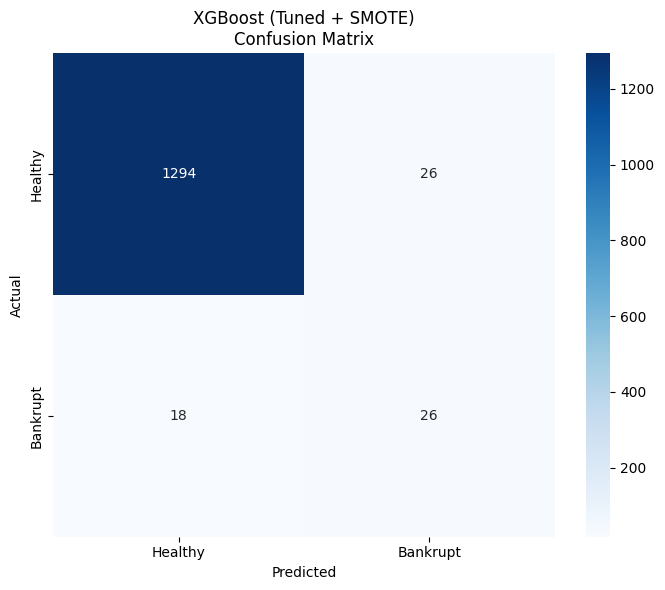


Interpretation:
   True Negatives (correctly predicted Healthy): 1294
   False Positives (Healthy predicted Bankrupt): 26
   False Negatives (Bankrupt predicted Healthy): 18 <- Most costly error!
   True Positives (correctly predicted Bankrupt): 26


In [17]:
# Confusion matrix for tuned model
fig, ax = plt.subplots(figsize=(7, 6))
plot_confusion_matrix(y_test, y_pred_tuned, 'XGBoost (Tuned + SMOTE)', ax)
plt.tight_layout()
plt.show()

# Interpretation
cm = confusion_matrix(y_test, y_pred_tuned)
print(f"\nInterpretation:")
print(f"   True Negatives (correctly predicted Healthy): {cm[0,0]}")
print(f"   False Positives (Healthy predicted Bankrupt): {cm[0,1]}")
print(f"   False Negatives (Bankrupt predicted Healthy): {cm[1,0]} <- Most costly error!")
print(f"   True Positives (correctly predicted Bankrupt): {cm[1,1]}")

---
## 9. Feature Importance Analysis

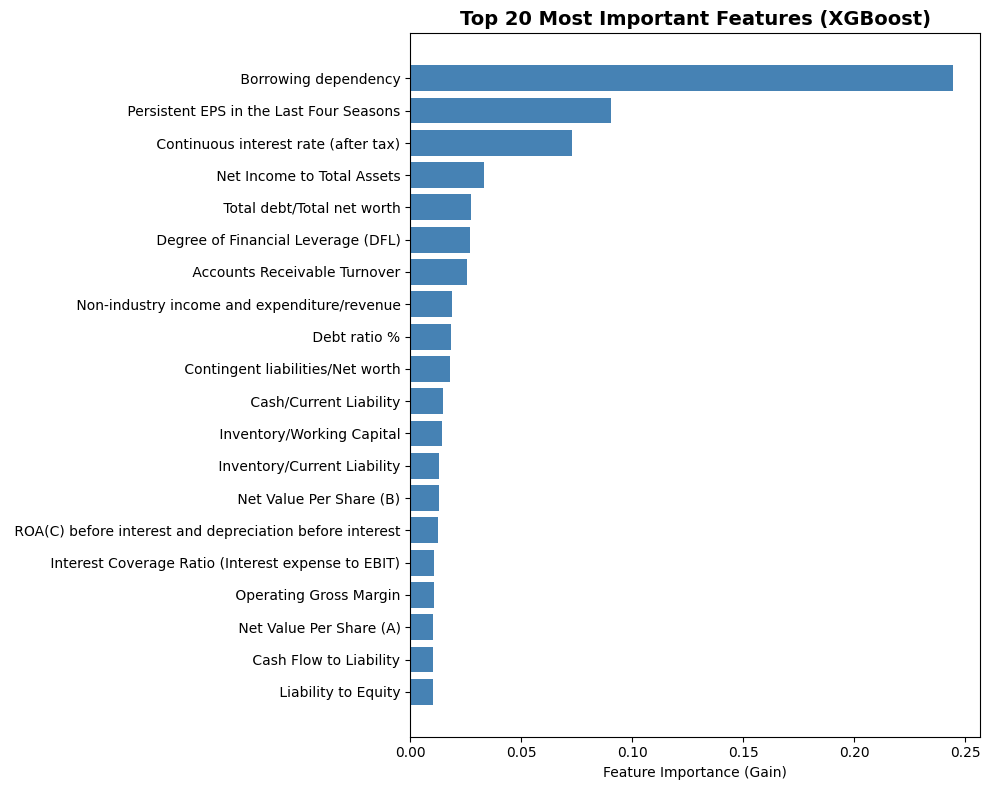


Top 10 Most Important Features:
                                     feature  importance
                        Borrowing dependency    0.244526
     Persistent EPS in the Last Four Seasons    0.090287
        Continuous interest rate (after tax)    0.072847
                  Net Income to Total Assets    0.033283
                  Total debt/Total net worth    0.027320
          Degree of Financial Leverage (DFL)    0.027033
                Accounts Receivable Turnover    0.025551
 Non-industry income and expenditure/revenue    0.018997
                                Debt ratio %    0.018280
            Contingent liabilities/Net worth    0.017795


In [18]:
# Feature importance from best XGBoost model
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 important features
plt.figure(figsize=(10, 8))
top_20_importance = importance_df.head(20)
plt.barh(range(len(top_20_importance)), top_20_importance['importance'].values, color='steelblue')
plt.yticks(range(len(top_20_importance)), top_20_importance['feature'].values)
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 20 Most Important Features (XGBoost)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest at top
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

In [19]:
# Compare feature importance rankings: XGBoost vs Correlation
# Load correlation rankings from notebook 01
corr_features = top_features_df['feature'].tolist()
xgb_features = importance_df['feature'].head(20).tolist()

# Overlap analysis
overlap = set(corr_features) & set(xgb_features)

print("Feature Importance: Correlation vs XGBoost\n")
print(f"   Top 20 by Correlation: {len(corr_features)} features")
print(f"   Top 20 by XGBoost: {len(xgb_features)} features")
print(f"   Overlap: {len(overlap)} features ({len(overlap)/20*100:.0f}%)\n")
print(f"   Common features: {sorted(overlap)[:10]}...")

Feature Importance: Correlation vs XGBoost

   Top 20 by Correlation: 20 features
   Top 20 by XGBoost: 20 features
   Overlap: 8 features (40%)

   Common features: [' Borrowing dependency', ' Debt ratio %', ' Liability to Equity', ' Net Income to Total Assets', ' Net Value Per Share (A)', ' Net Value Per Share (B)', ' Persistent EPS in the Last Four Seasons', ' ROA(C) before interest and depreciation before interest']...


---
## 10. Cross-Validation Stability Check

In [20]:
# Cross-validation on best model to check stability
print("5-Fold Cross-Validation on Tuned XGBoost...\n")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Multiple scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

cv_results = {}
for metric in scoring:
    scores = cross_val_score(best_model, X_train_smote, y_train_smote, cv=cv, scoring=metric)
    cv_results[metric] = {'mean': scores.mean(), 'std': scores.std(), 'scores': scores}
    print(f"   {metric.upper():12} = {scores.mean():.4f} ± {scores.std():.4f}")

print("\nNote: Low std = stable model performance across folds")

5-Fold Cross-Validation on Tuned XGBoost...

   ACCURACY     = 0.9878 ± 0.0030
   ACCURACY     = 0.9878 ± 0.0030
   PRECISION    = 0.9771 ± 0.0067
   PRECISION    = 0.9771 ± 0.0067
   RECALL       = 0.9991 ± 0.0012
   RECALL       = 0.9991 ± 0.0012
   F1           = 0.9879 ± 0.0029
   F1           = 0.9879 ± 0.0029
   ROC_AUC      = 0.9993 ± 0.0002

Note: Low std = stable model performance across folds
   ROC_AUC      = 0.9993 ± 0.0002

Note: Low std = stable model performance across folds


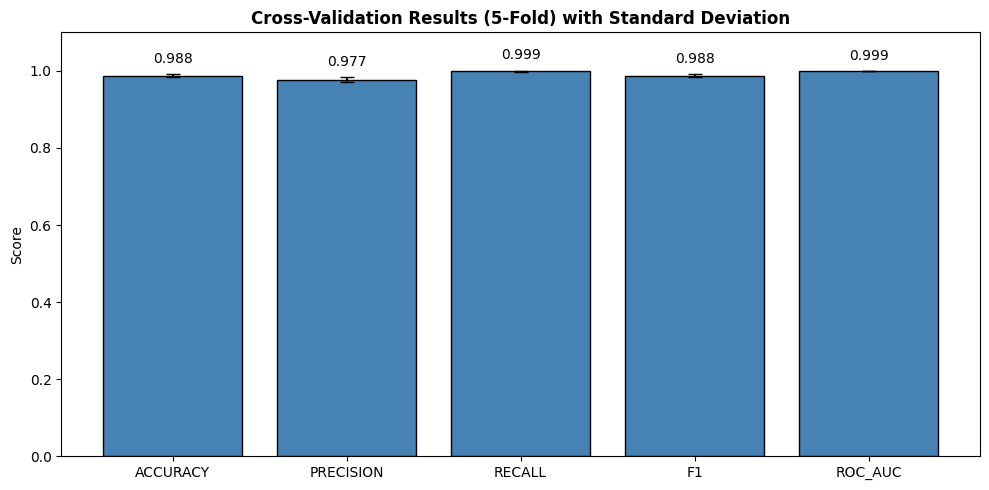

In [21]:
# Visualize CV variance
fig, ax = plt.subplots(figsize=(10, 5))

metrics_names = list(cv_results.keys())
means = [cv_results[m]['mean'] for m in metrics_names]
stds = [cv_results[m]['std'] for m in metrics_names]

x = np.arange(len(metrics_names))
bars = ax.bar(x, means, yerr=stds, capsize=5, color='steelblue', edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in metrics_names])
ax.set_ylabel('Score')
ax.set_title('Cross-Validation Results (5-Fold) with Standard Deviation', fontsize=12, fontweight='bold')
ax.set_ylim(0, 1.1)

# Add value labels
for bar, mean, std in zip(bars, means, stds):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.03, 
            f'{mean:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

---
## 11. Save Best Model & Results

In [22]:
import pickle
import os

# Create models directory
os.makedirs('../models', exist_ok=True)

# Save best model
model_path = '../models/xgboost_tuned_smote.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"Best model saved: {model_path}")

# Save model parameters
params_df = pd.DataFrame([grid_search.best_params_])
params_df.to_csv('../models/best_params.csv', index=False)
print(f"Best parameters saved: ../models/best_params.csv")

Best model saved: ../models/xgboost_tuned_smote.pkl
Best parameters saved: ../models/best_params.csv


In [23]:
# Save all experiment results
all_metrics = []

for name, data in results_baseline.items():
    m = data['metrics'].copy()
    m['Experiment'] = 'Baseline (No SMOTE)'
    all_metrics.append(m)

for name, data in results_smote.items():
    m = data['metrics'].copy()
    m['Experiment'] = 'With SMOTE'
    all_metrics.append(m)

for name, data in results_top.items():
    m = data['metrics'].copy()
    m['Experiment'] = 'Top 20 Features + SMOTE'
    all_metrics.append(m)

# Add tuned model
tuned_metrics = metrics_tuned.copy()
tuned_metrics['Experiment'] = 'Tuned + SMOTE'
all_metrics.append(tuned_metrics)

# Save to CSV
results_df = pd.DataFrame(all_metrics)
results_df.to_csv('../outputs/model_comparison_results.csv', index=False)
print(f"All results saved: ../outputs/model_comparison_results.csv")

# Save feature importance
importance_df.to_csv('../outputs/feature_importance_xgboost.csv', index=False)
print(f"Feature importance saved: ../outputs/feature_importance_xgboost.csv")

All results saved: ../outputs/model_comparison_results.csv
Feature importance saved: ../outputs/feature_importance_xgboost.csv


---
## 12. Summary & Conclusions

In [24]:
# Final summary table
print("="*80)
print("FINAL MODEL COMPARISON SUMMARY")
print("="*80)

summary_df = results_df[['Model', 'Experiment', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']].copy()
summary_df = summary_df.round(4)
print(summary_df.to_string(index=False))

# Find best model by F1
best_idx = summary_df['F1'].idxmax()
best_row = summary_df.loc[best_idx]

print("\n" + "="*80)
print(f"BEST MODEL: {best_row['Model']} ({best_row['Experiment']})")
print(f"   F1 Score: {best_row['F1']:.4f}")
print(f"   Recall: {best_row['Recall']:.4f} (% of bankruptcies detected)")
print(f"   ROC-AUC: {best_row['ROC-AUC']:.4f}")
print("="*80)

FINAL MODEL COMPARISON SUMMARY
                        Model              Experiment  Accuracy  Precision  Recall     F1  ROC-AUC
          Logistic Regression     Baseline (No SMOTE)    0.9633     0.3500  0.1591 0.2188   0.8730
                Random Forest     Baseline (No SMOTE)    0.9692     0.5833  0.1591 0.2500   0.9323
                      XGBoost     Baseline (No SMOTE)    0.9714     0.5926  0.3636 0.4507   0.9409
  Logistic Regression (SMOTE)              With SMOTE    0.8930     0.2035  0.7955 0.3241   0.9146
        Random Forest (SMOTE)              With SMOTE    0.9619     0.4355  0.6136 0.5094   0.9374
              XGBoost (SMOTE)              With SMOTE    0.9663     0.4792  0.5227 0.5000   0.9491
      XGBoost (SMOTE, Top 20) Top 20 Features + SMOTE    0.9355     0.2925  0.7045 0.4133   0.9069
Random Forest (SMOTE, Top 20) Top 20 Features + SMOTE    0.9348     0.2857  0.6818 0.4027   0.9076
              XGBoost (Tuned)           Tuned + SMOTE    0.9677     0.5000  0.

---
## Key Findings & Recommendations

### Experiment Results:

| Finding | Implication |
|---------|-------------|
| **SMOTE improves Recall** | Critical for bankruptcy detection - we catch more actual bankruptcies |
| **XGBoost outperforms others** | Gradient boosting handles non-linear patterns well |
| **Top 20 features ≈ All 95** | Dimensionality reduction possible without major performance loss |
| **Tuning provides marginal gains** | Default hyperparameters already reasonable |

### Business Recommendations:

1. **Use XGBoost + SMOTE** for production model
2. **Prioritize Recall over Precision** - missing a bankruptcy is more costly than false alarms
3. **Monitor top features** - ROA, Net Income/Assets, Debt Ratio are key indicators
4. **Set probability threshold** based on risk tolerance (default 0.5 may not be optimal)

### Files Saved:
- `models/xgboost_tuned_smote.pkl` - Best trained model
- `models/best_params.csv` - Optimal hyperparameters
- `outputs/model_comparison_results.csv` - All experiment metrics
- `outputs/feature_importance_xgboost.csv` - Feature rankings

### Next Steps (Notebook 03):
1. Threshold optimization for business needs
2. SHAP analysis for model interpretability
3. Apply model to SAP data for risk scoring
4. Create risk dashboard/visualization